In [34]:
# Import libraries:
import numpy as np
import scipy
import scipy.stats as st
from scipy.stats import cauchy
from scipy.stats import gamma
from scipy.signal import find_peaks
from sklearn.neighbors import KernelDensity
from sklearn import mixture
import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor
from functools import partial

from matplotlib.ticker import ScalarFormatter, NullFormatter

params = {'axes.labelsize': 24, 
          'xtick.labelsize': 20, 
          'xtick.direction': 'in',
          'xtick.major.size': 8.0,
          'xtick.bottom': 1,
          'xtick.top': 1,
          'ytick.labelsize': 20, 
          'ytick.direction': 'in',
          'ytick.major.size': 8.0,
          'ytick.left': 1,
          'ytick.right': 1,
#           'xtick.which': 'both',
          'text.usetex': True, 
          'lines.linewidth': 1,
          'axes.titlesize': 32,
          'font.family': 'serif'}
plt.rcParams.update(params)
columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Functions

In [19]:
def crit_window_width(x, k, widths, x_eval_kde=None):
    # x is the array with data
    # k is number of peaks for which we want the critical window width
    # widths is the array with window widths to use to find the critical one for each number of peaks
    # x_eval_kde has the positions where the KDE will be evaluated
    # It returns the critical window width, i.e. the minimum window width, for the kde to have at most k peaks. A smaller window produces mode than k peaks 
    
# Binary search to find critical, 
    if (x_eval_kde is None):
        x_eval_kde = np.linspace(min(x), max(x), 1000)
    lo = 0
    hi = len(widths)
    N_peaks = 0
    while lo <= hi:
        mid = (lo+hi)//2
        w = widths[mid]
        kd = KernelDensity(bandwidth=w, kernel='gaussian')
        kd.fit(x[:, None])
        logprob = kd.score_samples(x_eval_kde[:, None])
        kde = np.exp(logprob)
        peaks, _ = find_peaks(kde)
        N_peaks = len(peaks)
        if (lo==hi): break
        if (N_peaks <= k):
            hi = mid
            if hi==0: 
                print ("Minimum window width achieved. Set up smaller values")
                return
        else:
            lo = mid+1
            if lo==len(widths): 
                print ("Maximum window width achieved. Set up larger values")
                return
    return w

In [20]:
def prob_silverman(data, k_peaks, widths, N_boots=1000, x_eval_kde=None):
# Calculate probabilities for having more than k_peaks in the data set 
# (Probability for rejecting the null hypothesis H0 that there are k peaks)
# (original algorithm by Silverman 1981, i.e. just counting peaks for each bootstrap sample)
# Smoothed bootstrap procedure as in Silverman 1981
# Check expressions in Silverman (1981) and a pedagogical explanation in
# http://adereth.github.io/blog/2014/10/12/silvermans-mode-detection-method-explained/

# This test is known to be conservative, in the sense that it is not rigorous at rejecting models with k peaks.
# In other words, in some cases there might be more than k statistically significant peaks, but the test still does not reject models with k peaks
# On the other hand, if the test rejects a model with k peaks, you can bet that there is in fact evidence for more peaks.

    if (len(np.shape(k_peaks)) == 0):
        k_peaks = np.array([k_peaks])

    if (x_eval_kde is None):
        x_eval_kde = np.linspace(min(data), max(data), 1000)
    
    h_crit = np.zeros(len(k_peaks))
    print ('Determining h_crit...')
    for i in range(len(k_peaks)): # k is number of peaks
        h_crit[i] = crit_window_width(data, k_peaks[i], widths, x_eval_kde)
#             h_crit[i] = crit_window_width(data, k_peaks[i], widths)
        # print ("N. of peaks=",k_peaks[i], "h_crit =",np.round(h_crit[i],4))
    print ("h_crit:", np.round(h_crit, 4))
    if (np.any(np.isnan(h_crit))):
        print ('NaN entries found in h_crit. It seems it needs to change widths interval.')
        return

    sigma = np.std(data)
    print ('Dispersion of data:',np.round(sigma,4))
    P = np.zeros(len(k_peaks))
    print ("Now calculate probabilities...")
    N = len(data)
    
    for k in range(len(k_peaks)):
        h_k = h_crit[k]
        one_over_sqrt = (1./np.sqrt(1. + h_k**2/sigma**2))
        kd = KernelDensity(bandwidth=h_k, kernel='gaussian')
        
        print ("N. of peaks:",k_peaks[k],"h_crit=",np.round(h_k,4))
        N_peaks = np.zeros(N_boots)
        
        for i in range(N_boots):
            sampled_data = np.random.choice(data, size=N)
            eps = np.random.normal(0, 1, N)
            smooth_data = one_over_sqrt*(sampled_data + h_k*eps)

            kd.fit(smooth_data[:, None])
            logprob = kd.score_samples(x_eval_kde[:, None])
            kde = np.exp(logprob)
            peaks, _ = find_peaks(kde)
            N_peaks[i] = len(peaks)
        
        P[k] = len(N_peaks[N_peaks<=k_peaks[k]])/N_boots
        print ("P=",P[k])
    return P

In [21]:
def parallel_prob_silverman(data, k_peaks, widths, N_boots=1000, x_eval_kde=None):
# Same as above but parallelizes bootstrap calculation
# It does not work in jupyter-notebook. It only works when running a python script (python script.py)
# To get a .py script from this file, in a jupyter-notebook go to File->Download as -> Python (.py)

# Calculate probabilities for having more than k_peaks in the data set 
# (original algorithm by Silverman 1981, i.e. just counting peaks for each bootstrap sample)
# Smoothed bootstrap procedure (original Silverman)
# Check expressions in Silverman (1981) and a pedagogical explanation in
# http://adereth.github.io/blog/2014/10/12/silvermans-mode-detection-method-explained/

# This test is known to be conservative, in the sense that it is not rigorous at rejecting models with less than k peaks.
# In other words, in some cases there might be more than k statistically significant peaks, but the test still does not reject models with less peaks
# On the other hand, if the test rejects a model with less than k peaks, you can bet that there is in fact evidence for more peaks.
# It returns the probability for having more than k peaks (modes)

    if (len(np.shape(k_peaks)) == 0):
        k_peaks = np.array([k_peaks])

    if (x_eval_kde is None):
        x_eval_kde = np.linspace(min(data), max(data), 1000)
    
    h_crit= np.zeros(len(k_peaks))
    for i in range(len(k_peaks)): # k is number of peaks
        h_crit[i] = crit_window_width(data, k_peaks[i], widths, x_eval_kde)
#             h_crit[i] = crit_window_width(data, k_peaks[i], widths)
    if (np.any(np.isnan(h_crit))):
        print ('NaN entries found in h_crit. It seems it needs to change widths interval.')
        return

    sigma = np.std(data)
    P = np.zeros(len(k_peaks))

    for k in range(len(k_peaks)):
        h_k = h_crit[k]
        N_peaks = np.zeros(N_boots)
        
        if __name__ == "__main__":
            with ProcessPoolExecutor() as pool:
# To avoid using global variables, and pass them as arguments:
                worker = partial(parallel_bootstrap, data=data, h_k=h_k, sigma=sigma, x_eval_kde=x_eval_kde)
                for j, out_N_peaks in pool.map(worker, range(N_boots)):
                    N_peaks[j] = out_N_peaks
                    
        P[k] = len(N_peaks[N_peaks<=k_peaks[k]])/N_boots
    return P

In [22]:
def parallel_bootstrap(j, data, h_k, sigma, x_eval_kde):
    N = len(data)
    one_over_sqrt = (1./np.sqrt(1. + h_k**2/sigma**2))
    kd = KernelDensity(bandwidth=h_k, kernel='gaussian')
        
    sampled_data = np.random.choice(data, size=N)
    eps = np.random.normal(0, 1, N)
    smooth_data = one_over_sqrt*(sampled_data + h_k*eps)

    kd.fit(smooth_data[:, None])
    logprob = kd.score_samples(x_eval_kde[:, None])
    kde = np.exp(logprob)
    peaks, _ = find_peaks(kde)
    N_peaks = len(peaks)
    
    return j, N_peaks

In [23]:
def lambda_alpha(alpha):
    # To use in calibrated version of Hall & York (2001)
    # Eq. 4.1 and table 2 from Hall & York (2001):
    a1 = 0.94029
    a2 = -1.59914
    a3 = 0.17695
    a4 = 0.48971
    a5 = -1.77793
    a6 = 0.36162
    a7 = 0.42423

    return (a1*alpha**3 + a2*alpha**2 + a3*alpha + a4)/(alpha**3 + a5*alpha**2 + a6*alpha + a7)

In [24]:
def prob_hall_york(data, k_peaks, widths, N_boots=1000, alpha=0.05, x_eval_kde=None):
# Calculate probabilities (using correction of Hall & York (2001): calculating h_k critic for each bootstrap sample)
# Smoothed bootstrap procedure 
# Calculates the probability for h_crit*/h_crit <= lambda_alpha, where:
# h_crit* is the h_crit for the bootstrap sample
# lambda_alpha is a function of the significance level alpha defined below
# Reject null hypothesis that the distribution has k peaks (against a model with more than k peaks) if P >= 1 - alpha, i.e. alpha determines the significance level.
# This has been calibrated only for k=1 in Hall & York (2001)

# Check expressions in Hall & York (2001)

    if (len(np.shape(k_peaks)) == 0):
        k_peaks = np.array([k_peaks])

    l_alpha = lambda_alpha(alpha)
    
    if (x_eval_kde is None):
        x_eval_kde = np.linspace(min(data), max(data), 1000)

    h_crit= np.zeros(len(k_peaks))
    print ('Determining h_crit...')
    for i in range(len(k_peaks)): # k is number of peaks
        h_crit[i] = crit_window_width(data, k_peaks[i], widths, x_eval_kde)
        # h_crit[i] = crit_window_width(data, k_peaks[i], widths)
        print ("N. of peaks=",k_peaks[i], "h_crit =",np.round(h_crit[i],4))
    print ("h_crit:", np.round(h_crit, 4))
    
    if (np.any(np.isnan(h_crit))):
        print ('NaN entries found in h_crit. It seems it needs to change widths interval.')
        return

    sigma = np.std(data)
    print ('Dispersion of data:',np.round(sigma,4))
    P = np.zeros(len(k_peaks))
    N = len(data)
    print ("Now calculate probabilities:")

    for k in range(len(k_peaks)):
        h_k = h_crit[k]
        one_over_sqrt = (1./np.sqrt(1. + h_k**2/sigma**2))
        
        print ("N. peaks=",k_peaks[k],"h_crit=",np.round(h_k,4))
        h_k_star = np.zeros(N_boots)
        
        for i in range(N_boots):
            sampled_data = np.random.choice(data, size=N)
            eps = np.random.normal(0, 1, N)
            smooth_data = one_over_sqrt*(sampled_data + h_k*eps)
# Binary search for critical window width of this bootstrap sample:
            h_k_star[i] = crit_window_width(smooth_data, k_peaks[k], widths, x_eval_kde)
        P[k] = len(h_k_star[h_k_star/h_k <= l_alpha])/N_boots
        print ("P=",P[k])
    return P

In [25]:
def parallel_prob_hall_york(data, k_peaks, widths, N_boots=1000, alpha=0.05, x_eval_kde=None):
# Same as above but parallelizes bootstrap calculation
# It does not work in jupyter-notebook. It only works when running a python script (python script.py)
# To get a .py script from this file, in a jupyter-notebook go to File->Download as -> Python (.py)

# Calculate probabilities (using correction of Hall & York (2001): calculating h_k critic for each bootstrap sample)
# Smoothed bootstrap procedure 
# Calculates the probability for h_crit*/h_crit <= lambda_alpha, where:
# h_crit* is the h_crit for the bootstrap sample
# lambda_alpha is a function of the significance level alpha defined below
# Reject null hypothesis that the distribution has k peaks (against a model with more than k peaks) if P >= 1 - alpha, i.e. alpha determines the significance level.
# This has been calibrated only for k=1 in Hall & York (2001)

# Check expressions in Hall & York (2001)

    if (len(np.shape(k_peaks)) == 0):
        k_peaks = np.array([k_peaks])

    l_alpha = lambda_alpha(alpha)
    
    if (x_eval_kde is None):
        x_eval_kde = np.linspace(min(data), max(data), 1000)

    h_crit= np.zeros(len(k_peaks))
    for i in range(len(k_peaks)): # k is number of peaks
        h_crit[i] = crit_window_width(data, k_peaks[i], widths, x_eval_kde)
        # h_crit[i] = crit_window_width(data, k_peaks[i], widths)
        
    if (np.any(np.isnan(h_crit))):
        print ('NaN entries found in h_crit. It seems it needs to change widths interval.')
        return

    sigma = np.std(data)
    P = np.zeros(len(k_peaks))
    N = len(data)

    for k in range(len(k_peaks)):
        h_k = h_crit[k]
        h_k_star = np.zeros(N_boots)
        
        if __name__ == "__main__":
            with ProcessPoolExecutor() as pool:
# To avoid using global variables, and pass them as arguments:
                worker = partial(parallel_bootstrap_hy, data=data, h_k=h_k, sigma=sigma, k_peaks=k_peaks[k], widths=widths, x_eval_kde=x_eval_kde)
                for j, out_h_k_star in pool.map(worker, range(N_boots)):
                    h_k_star[j] = out_h_k_star
                
        P[k] = len(h_k_star[h_k_star/h_k <= l_alpha])/N_boots
    return P

In [26]:
def parallel_bootstrap_hy(j, data, h_k, sigma, k_peaks, widths, x_eval_kde):
    N = len(data)
    one_over_sqrt = (1./np.sqrt(1. + h_k**2/sigma**2))
        
    sampled_data = np.random.choice(data, size=N)
    eps = np.random.normal(0, 1, N)
    smooth_data = one_over_sqrt*(sampled_data + h_k*eps)

    # Binary search for critical window width of this bootstrap sample:
    h_k_star = crit_window_width(smooth_data, k_peaks, widths, x_eval_kde)
    
    return j, h_k_star

# Test with a mixture of two Gamma functions

In [27]:
x_kde = np.linspace(0, 20, 1000)

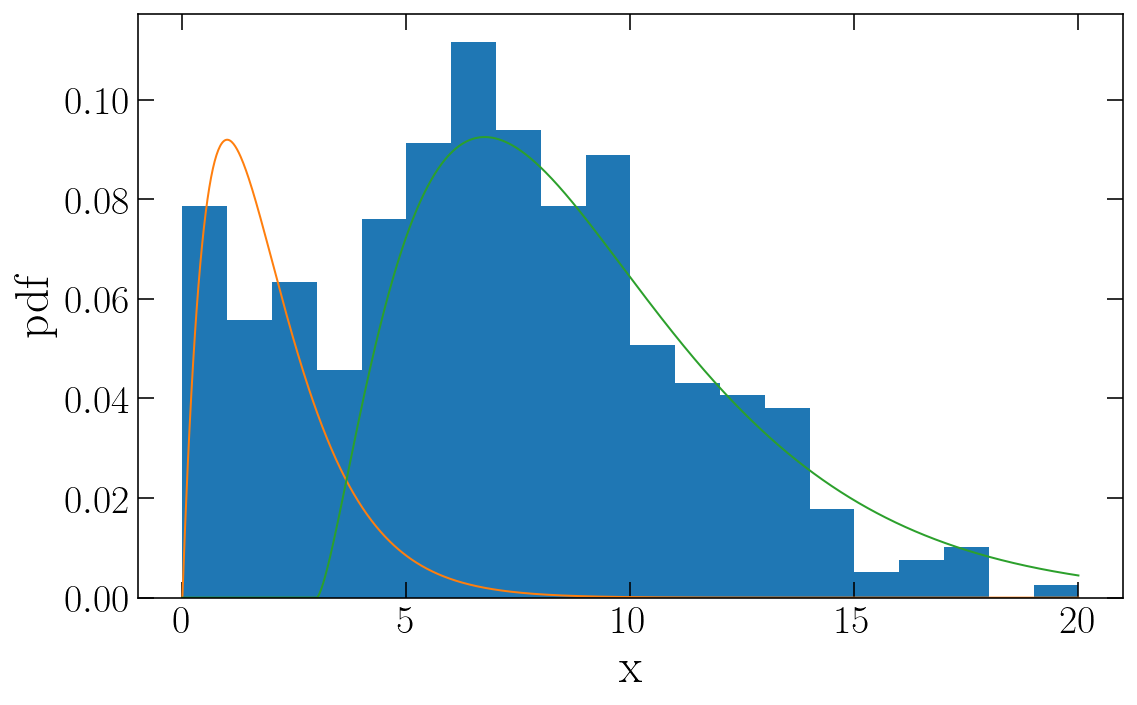

In [52]:
# Generate mixed distribution, plot hist and pdf's
# Fix seed to generate same values:
np.random.seed(0)

a1 = 2
a2 = 2.5

gamma_1 = gamma(a=a1, loc=0, scale=1)
gamma_2 = gamma(a=a2, loc=3, scale=2.5)

size1 = 100
size2 = 300
w1 = size1/(size1+size2)
w2 = size2/(size1+size2)
# Generate  random numbers from mixtures of two distributions:
x = np.concatenate((gamma_1.rvs(size=size1), gamma_2.rvs(size=size2)))

fig, axs = plt.subplots(1, figsize=(8,5))
axs.hist(x, range=(0, 20), bins=20, density=True)
axs.plot(x_kde, w1*gamma_1.pdf(x_kde))
axs.plot(x_kde, w2*gamma_2.pdf(x_kde))
axs.set_xlabel('x')
axs.set_ylabel('pdf')

plt.tight_layout()

In [55]:
# Set up array with widths and numbers of peaks to be tested:

# Array used to search for critical widths
# It depends on the typical values of the data
# If it doesn't cover the required values, a message is shown.
widths = np.linspace(0.0, 10., 1000) 

# Numbers of peaks to be tested:
k_peaks = np.arange(1, 4, 1)
# k_peaks = 1

In [56]:
# First find probabilities with the non-callibrated original Silverman test:

P_silverman = prob_silverman(x, k_peaks, widths=widths, N_boots=1000, x_eval_kde=x_kde)
# To run in parallel, you need to run a .py script:
# P_silverman = parallel_prob_silverman(x, k_peaks, widths=widths, N_boots=1000, x_eval_kde=x_kde)
print ('----------')
print ('Probabilities of having more than')
print (k_peaks)
print ('peaks:')
print (P_silverman)

Determining h_crit...
h_crit: [1.2312 0.7608 0.6507]
Dispersion of data: 4.4079
Now calculate probabilities...
N. of peaks: 1 h_crit= 1.2312
P= 0.854
N. of peaks: 2 h_crit= 0.7608
P= 0.31
N. of peaks: 3 h_crit= 0.6507
P= 0.331
----------
Probabilities of having more than
[1 2 3]
peaks:
[0.854 0.31  0.331]


In [31]:
# Now for the callibrated version of Hall & York (2001)
# only calibrated for k=1

P_hy = prob_hall_york(x, k_peaks, widths=widths, N_boots=1000, x_eval_kde=x_kde)
# To run in parallel, you need to run a .py script:
# P_hy = parallel_prob_hall_york(x, k_peaks, widths=widths, N_boots=1000, x_eval_kde=x_kde)

Determining h_crit...
N. of peaks= 1 h_crit = 1.2312
N. of peaks= 2 h_crit = 0.7608
N. of peaks= 3 h_crit = 0.6507
h_crit: [1.2312 0.7608 0.6507]
Dispersion of data: 4.4079
Now calculate probabilities:
N. peaks= 1 h_crit= 1.2312
P= 0.946
N. peaks= 2 h_crit= 0.7608
P= 0.591
N. peaks= 3 h_crit= 0.6507
P= 0.648


In [32]:
print ('Probabilities of having more than')
print (k_peaks)
print ('peaks:')
print (P_hy)

Probabilities of having more than
[1 2 3]
peaks:
[0.946 0.591 0.648]


In [57]:
# Calc most detailed kde having at most 2 peaks (i.e. with critical window width for 2 peaks):

h_crit = np.zeros(len(k_peaks))

for i in range(len(k_peaks)):
    h_crit[i] = crit_window_width(x, k_peaks[i], widths)
    
kd = KernelDensity(bandwidth=h_crit[2], kernel='gaussian')
kd.fit(x[:, None])
logprob = kd.score_samples(x_kde[:, None])
kde = np.exp(logprob)

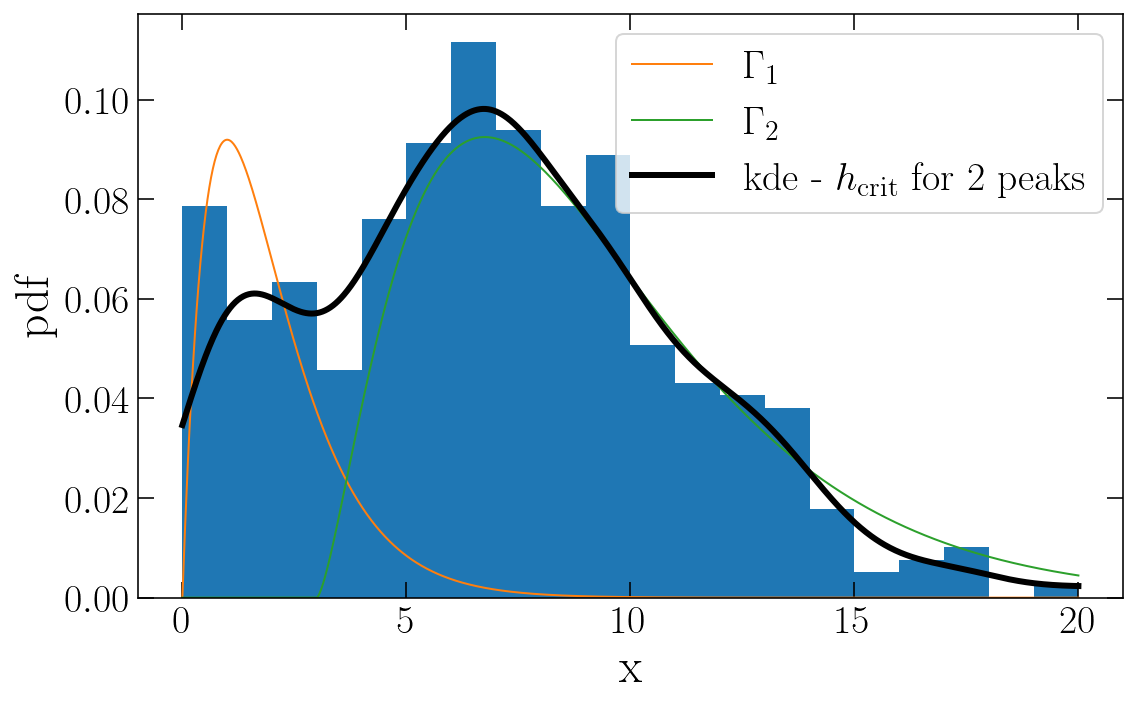

In [64]:
fig, axs = plt.subplots(1, figsize=(8,5))
axs.hist(x, range=(0, 20), bins=20, density=True)
axs.plot(x_kde, w1*gamma_1.pdf(x_kde), label=r'$\Gamma_1$')
axs.plot(x_kde, w2*gamma_2.pdf(x_kde), label=r'$\Gamma_2$')
axs.plot(x_kde, kde, 'k-', lw=3, label='kde - $h_\mathrm{crit}$ for 2 peaks')
axs.set_xlabel('x')
axs.set_ylabel('pdf')
axs.legend(fontsize=20)

plt.tight_layout()

# Test with Gaussian Mixture Models

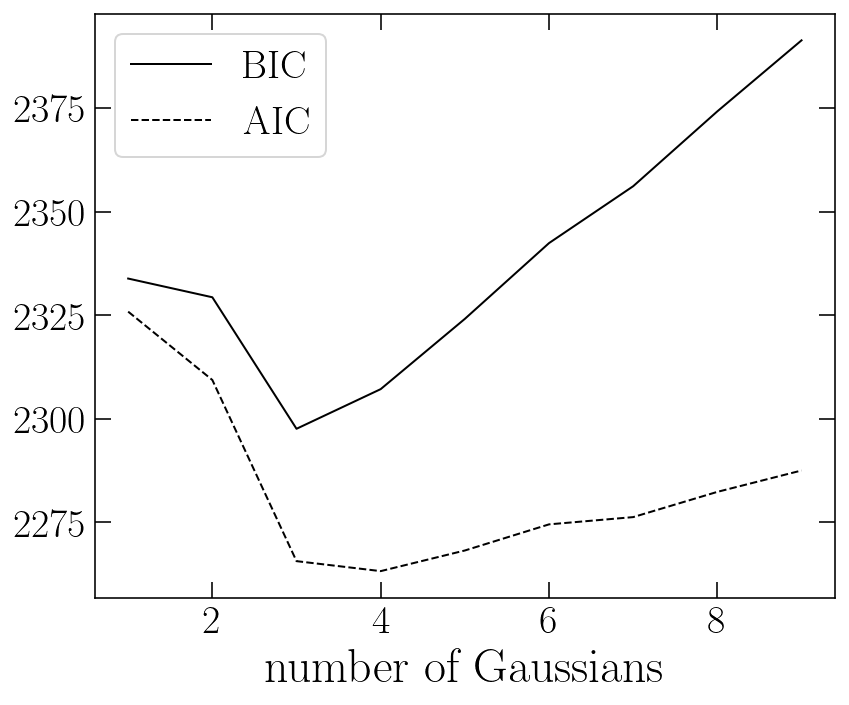

In [50]:
# If we want to decide how many Gaussians the data favour:
# Now fit Gaussian Mixture Models to data
# The routine requires I re-shape the data
GMM_x = np.array(x).reshape(-1,1)

n_comps = np.arange(1, 10)
models = [None for i in range(len(n_comps))]

for i in range(len(n_comps)):
    models[i] = mixture.GaussianMixture(n_comps[i]).fit(GMM_x)

# compute the AIC and the BIC
AIC = [m.aic(GMM_x) for m in models]
BIC = [m.bic(GMM_x) for m in models]

fig, axs = plt.subplots(1, figsize=(6,5))

axs.plot(n_comps, BIC, 'k-', label='BIC')
axs.plot(n_comps, AIC, 'k--', label='AIC')
axs.set_xlabel('number of Gaussians')

axs.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# The GMM might drive one to the wrong conclusion of statistical significance for 3 peaks